In [17]:
INTERACTIVE_PLOTS = True

if INTERACTIVE_PLOTS:
    get_ipython().magic('matplotlib notebook')
else:
    get_ipython().magic('matplotlib inline')

# Test AMDC Class

In [1]:
from AMDC import AMDC

In [2]:
USE_ETHERNET = True

if not USE_ETHERNET:
    amdc = AMDC()
    amdc.setup_comm_defaults('uart')
    amdc.uart_init('COM6')
else:
    amdc = AMDC()
    amdc.setup_comm_defaults('eth')
    amdc.eth_init()
    s0, s0_id = amdc.eth_new_socket('ascii_cmd')
    amdc.eth_set_default_ascii_cmd_socket(s0)

In [3]:
amdc.connect()

In [18]:
amdc.disconnect()

# Set Up Logging

In [4]:
from AMDC_Logger import AMDC_Logger, find_mapfile

In [5]:
mfpath = find_mapfile(r'C:\Users\Nathan\Documents\GitHub\AMDC-Firmware\sdk\app_cpu1')
logger = AMDC_Logger(amdc, mfpath)

In [6]:
logger.sync()
logger.info()

	> log info
	> log info
###################   AMDC LOGGER INFO   ###################

Variable Name:      Index:         Type:         Sample Rate [Hz]:    Number of Samples:
LOG_vsi_a             0            double              100.0                 0       
LOG_vsi_b             1            float               100.0                 0       
LOG_vsi_c             2             int                100.0                 0       
LOG_task_vsi_runs       3             int                100.0                 0       



In [7]:
logger.unregister_all()
samples_per_sec = 100
logger.register('vsi_a', var_type = 'double', samples_per_sec = samples_per_sec)
logger.register('vsi_b', var_type = 'float', samples_per_sec = samples_per_sec)
logger.register('vsi_c', var_type = 'int', samples_per_sec = samples_per_sec)
logger.register('task_vsi_runs', var_type = 'int', samples_per_sec = samples_per_sec)

	> log unreg 0
['log unreg 0', 'SUCCESS']
	> log unreg 1
['log unreg 1', 'SUCCESS']
	> log unreg 2
['log unreg 2', 'SUCCESS']
	> log unreg 3
['log unreg 3', 'SUCCESS']
	> log reg 0 LOG_vsi_a 537542928 100 double
['log reg 0 LOG_vsi_a 537542928 100 double', 'SUCCESS']
	> log reg 1 LOG_vsi_b 537542936 100 float
['log reg 1 LOG_vsi_b 537542936 100 float', 'SUCCESS']
	> log reg 2 LOG_vsi_c 537542940 100 int
['log reg 2 LOG_vsi_c 537542940 100 int', 'SUCCESS']
	> log reg 3 LOG_task_vsi_runs 537542912 100 int
['log reg 3 LOG_task_vsi_runs 537542912 100 int', 'SUCCESS']


# Test Buffered Logging

In [9]:
logger.clear_all()
logger.log(1)

	> log empty_all
['log empty_all', 'SUCCESS']
	> log start
['log start', 'SUCCESS']
	> log stop
['log stop', 'SUCCESS']


In [10]:
for i in range(1):
    data = logger.dump(how='binary', max_tries = 1)

	> log dump eth bin 0
Dumping: LOG_vsi_a
Dump took: 0.045  sec
Dump rate: 2295.123  sps
Num samples: 103 

	> log dump eth bin 1
Dumping: LOG_vsi_b
Dump took: 0.043  sec
Dump rate: 2388.424  sps
Num samples: 103 

	> log dump eth bin 2
Dumping: LOG_vsi_c
Dump took: 0.052  sec
Dump rate: 1981.703  sps
Num samples: 103 

	> log dump eth bin 3
Dumping: LOG_task_vsi_runs
Dump took: 0.053  sec
Dump rate: 1948.305  sps
Num samples: 103 



<IPython.core.display.Javascript object>


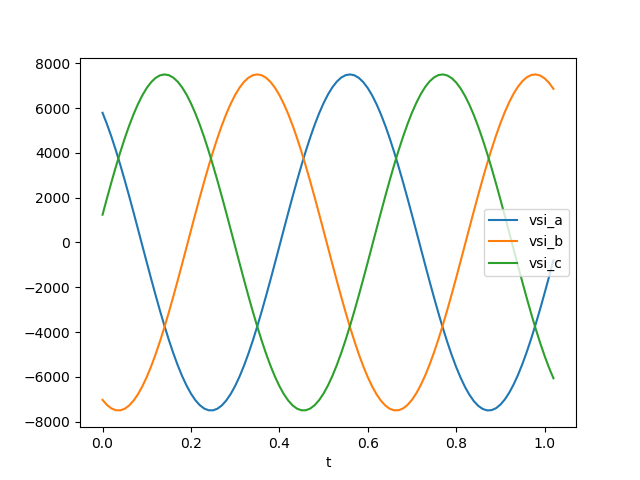

In [18]:
data['vsi_a vsi_b vsi_c'.split()].plot()

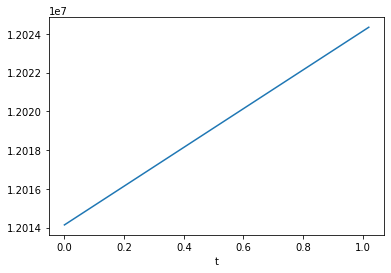

In [13]:
data['task_vsi_runs'].plot()

# Test Streaming Logging

In [19]:
from AMDC_LivePlot import AMDC_LivePlot

In [24]:
p1.stop_stream()

	> log stream stop 0 1
['log stream stop 0 1', 'SUCCESS']


<IPython.core.display.Javascript object>


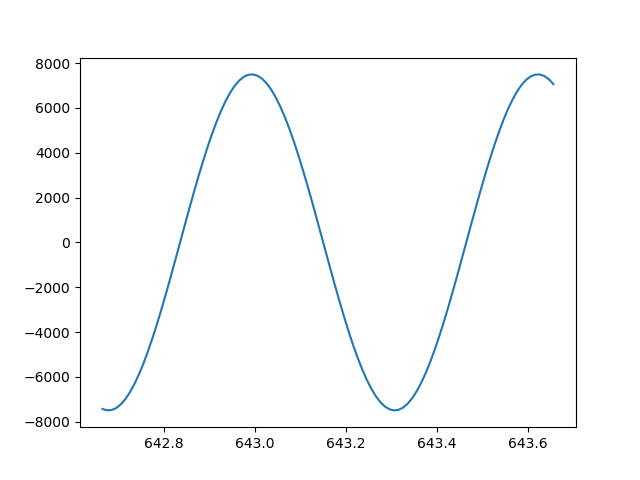

In [22]:
p1 = AMDC_LivePlot(logger, 'vsi_a', window_sec = 1)

<IPython.core.display.Javascript object>


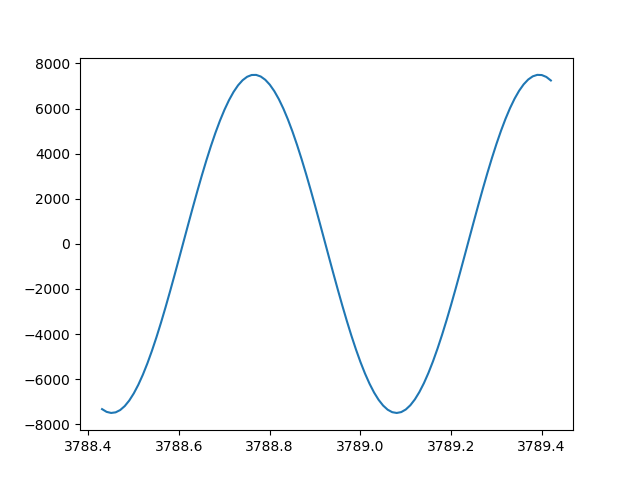

	> log stream start 0 1
['log stream start 0 1', 'SUCCESS']


In [20]:
p1 = AMDC_LivePlot(logger, 'vsi_a', window_sec = 1)
p1.start_stream()

In [21]:
p1.stop_stream()

	> log stream stop 0 1
['log stream stop 0 1', 'SUCCESS']


<IPython.core.display.Javascript object>


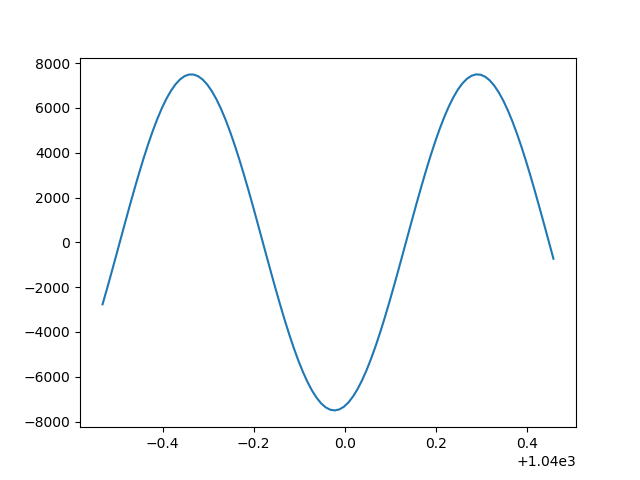

	> log stream start 1 3
['log stream start 1 3', 'SUCCESS']


In [14]:
p2 = AMDC_LivePlot(logger, 'vsi_b', window_sec=1)
p2.start_stream()
p2.show()

<IPython.core.display.Javascript object>


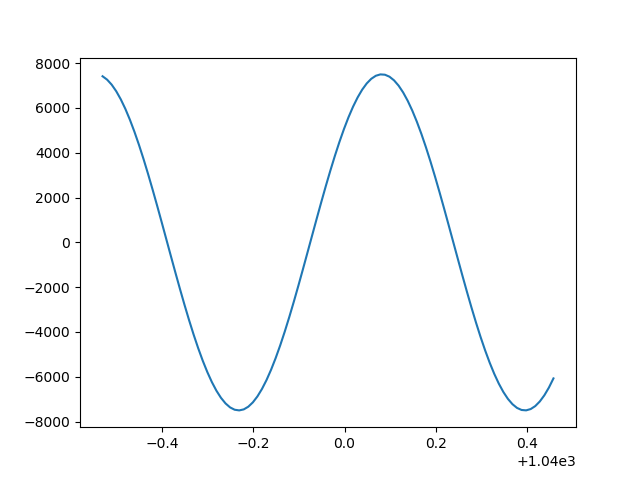

	> log stream start 2 4
['log stream start 2 4', 'SUCCESS']


In [15]:
p3 = AMDC_LivePlot(logger, 'vsi_c', window_sec=1)
p3.start_stream()
p3.show()

<IPython.core.display.Javascript object>


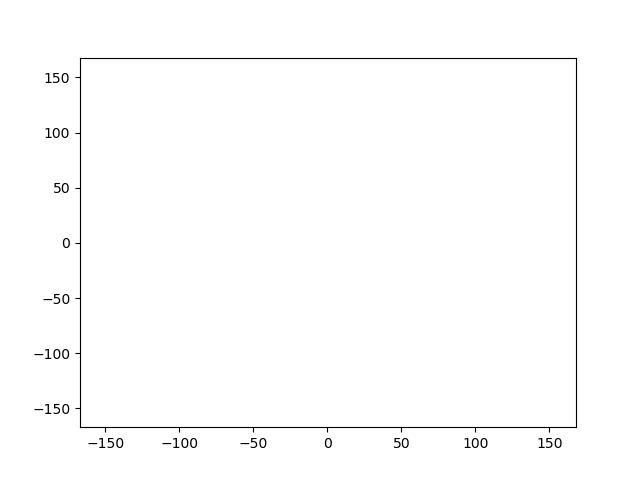

	> log stream start 3 5
['log stream start 3 5', 'INVALID ARGUMENTS']


In [16]:
p4 = AMDC_LivePlot(logger, 'task_vsi_runs', window_sec=1)
p4.start_stream()
p4.show()

In [8]:
p1.stop_stream()
p2.stop_stream()
p3.stop_stream()
p4.stop_stream()

NameError: name 'p1' is not defined